# BN003: Transcriptional Profile of Tuft Cells & Their Neuronal Signatures (scRNA-seq)

## Imports

In [86]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
import anndata as ad

## Functions

In [88]:
def read_matrix_files(file_base, samples):
    """
    Takes a file base (string) and a list of samples
    Returns a dictionary with the sample name as the key and the corresponding Anndata object as value
    """
    sample_dict = dict()
    for sample in samples: 
        ad = sc.read(file_base + sample + matrix_suffix)
        
        # Scanpy expects cells x genes, GEO stores genes x cells
        ad = ad.transpose()
        
        # read in barcode and gene files, they are stored as tsvs
        barcodes = pd.read_csv(file_base + sample + barcode_suffix, header=None, sep='\t')
        genes = pd.read_csv(file_base + sample + gene_suffix, header=None, sep='\t')

        # Annotate data
        ad.obs_names = sample + '#' + ad.obs_names

        barcodes.rename(columns={0:'barcode'}, inplace=True)
        barcodes.set_index('barcode', inplace=True)
        ad.obs = barcodes
        
        if len(genes.columns) == 3:
            genes.rename(columns={0:'gene_ids', 1:'gene', 2: 'feature_types'}, inplace=True)
        if len(genes.columns) == 2:
            genes.rename(columns={0:'gene_ids', 1:'gene'}, inplace=True)
        else:
            genes.rename(columns={0:'gene'}, inplace=True)
        genes.set_index('gene', inplace=True)
        ad.var = genes

        # Add sample info to dictionary
        sample_dict[sample] = ad
        sample_dict[sample].var_names_make_unique()
        
        # Set the .obs['sample'] to the sample name
        sample_dict[sample].obs['sample'] = sample
        
    return sample_dict

In [89]:
def read_matrix_file(file_base, sample):
    """
    Takes a file base (string) and a sample name (string)
    Returns Anndata object as value
    """ 
    ad = sc.read(file_base + sample + matrix_suffix)
    # Scanpy expects cells x genes, GEO stores genes x cells
    ad = ad.transpose()
    # read in barcode and gene files, they are stored as tsvs
    barcodes = pd.read_csv(file_base + sample + barcode_suffix, header=None, sep='\t')
    genes = pd.read_csv(file_base + sample + gene_suffix, header=None, sep='\t')

    barcodes.rename(columns={0:'barcode'}, inplace=True)
    barcodes.set_index('barcode', inplace=True)
    ad.obs = barcodes
    
    if len(genes.columns) == 3:
        genes.rename(columns={0:'gene_ids', 1:'gene', 2: 'feature_types'}, inplace=True)
    if len(genes.columns) == 2:
        genes.rename(columns={0:'gene_ids', 1:'gene'}, inplace=True)
    else:
        genes.rename(columns={0:'gene'}, inplace=True)
    genes.set_index('gene', inplace=True)
    ad.var = genes
    ad.var_names_make_unique()

    ad.var['mt'] = ad.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False)
    return ad

In [90]:
def basic_metrics(samples, sample_dict):
    """
    Takes list of samples and dictionary of samples generated from the read_matrix_files function
    Returns a dictionary of barcodes from the samples with computed quality metrics
    """
    sample_cells = dict()
    for sample in samples:
        sample_cells[sample] = sample_dict[sample].obs_names
        ad = sample_dict[sample]
        ad.var['mt'] = ad.var_names.str.startswith('mt-')
        sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False)
    return sample_cells

In [107]:
def graph_qc(ad, THRESHOLDS=np.zeros(2)):
    """
    Take an Anndata object
    Display 3 QC graphs: molecules per cell, genes per cell, mitochondrial genes per cell
    """
    plt.figure()
    if all(i == 0 for i in THRESHOLDS):
        THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3, 98]))
    figs, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].hist(np.log10(ad.obs['total_counts']), 50)
    axs[0].set_xlabel('log10(nUMI/cell)')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(ad.obs['n_genes_by_counts'], 50)
    axs[1].set_xlabel('nGenes/cell')
    axs[1].set_ylabel('Frequency')

    axs[2].hist(ad.obs['pct_counts_mt'], 50)
    axs[2].set_xlabel('% Mitochondrial genes /cell')
    axs[2].set_ylabel('Frequency')
    sns.despine()

In [117]:
def merge(samples, sample_dict, sample_cells):
    """
    Returns merged Anndata object of all the samples
    """
    sample = samples[0]
    ad = sample_dict[sample][sample_cells[sample]]
    for sample in samples[1:]:
        ad = ad.concatenate(sample_dict[sample][sample_cells[sample]],
                            index_unique=None, batch_key='batch')
    ad.obs_names_make_unique()
    # Clean up var object
    ad.var = pd.DataFrame(index=ad.var_names)
    return ad

In [93]:
def cluster(ad, algorithm, num_neighbors, pcs, res, num_top_genes):
    """
    Selects the top n most variable genes, performs PCA on these genes, keeps n PCs, calculates kNN graph on n neighbors (default), and performs Leiden algorithm (res = 1.0 default)
    Returns updated AnnData object

    ad: AnnDataObject
    algorithm: str
    num_neighbors: int 
    pcs: int
    res: int
    num_top_genes: int
    """
    # calculate highly variable genes, keep top 1500
    sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=num_top_genes)
    
    # PCA using HVG
    sc.pp.pca(ad, use_highly_variable=True, n_comps=pcs)
    sc.pp.neighbors(ad, n_neighbors=num_neighbors, use_rep='X_pca')
    
    if algorithm == 'phenograph':
        # Phenograph
        ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
        ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
        
    if algorithm == 'leiden':
        key = 'leiden_' + str(res)
        sc.tl.leiden(ad, resolution=res, key_added=key)
        
    return ad

**PNAS Dataset**

## Load Data

In [96]:
# Set up file name definitions
samples_uninfected = ['GSM5182803_10x-Estes-02', 'GSM5182804_10x-Estes-03', 'GSM5182806_10x-Estes-05']
file_base = 'Data/Bomidi_et_al//GSE169197_RAW/'
matrix_suffix = '_matrix.mtx.gz'
barcode_suffix = '_barcodes.tsv.gz'
gene_suffix = '_features.tsv.gz'

In [99]:
uninfected_dict = read_matrix_files(file_base, samples_uninfected)
uninfected_dict

{'GSM5182803_10x-Estes-02': AnnData object with n_obs × n_vars = 737280 × 55432
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 'GSM5182804_10x-Estes-03': AnnData object with n_obs × n_vars = 6794880 × 55432
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 'GSM5182806_10x-Estes-05': AnnData object with n_obs × n_vars = 6794880 × 55432
     obs: 'sample'
     var: 'gene_ids', 'feature_types'}

## Quality Control

In [100]:
uninfected_cells = basic_metrics(samples_uninfected, uninfected_dict)

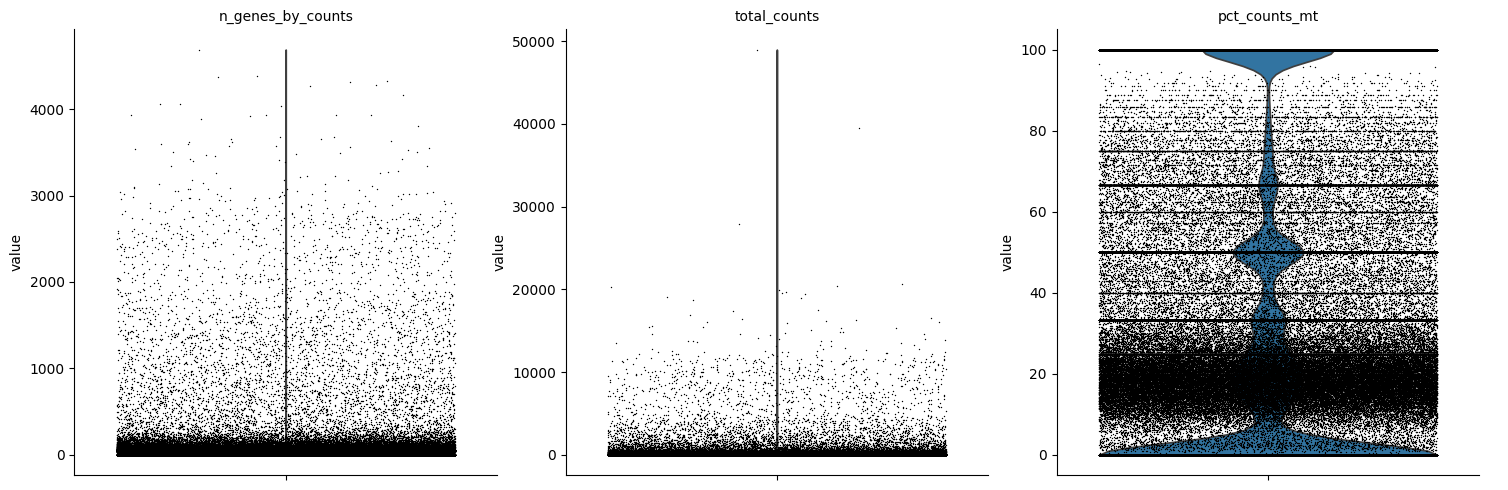

<Figure size 640x480 with 0 Axes>

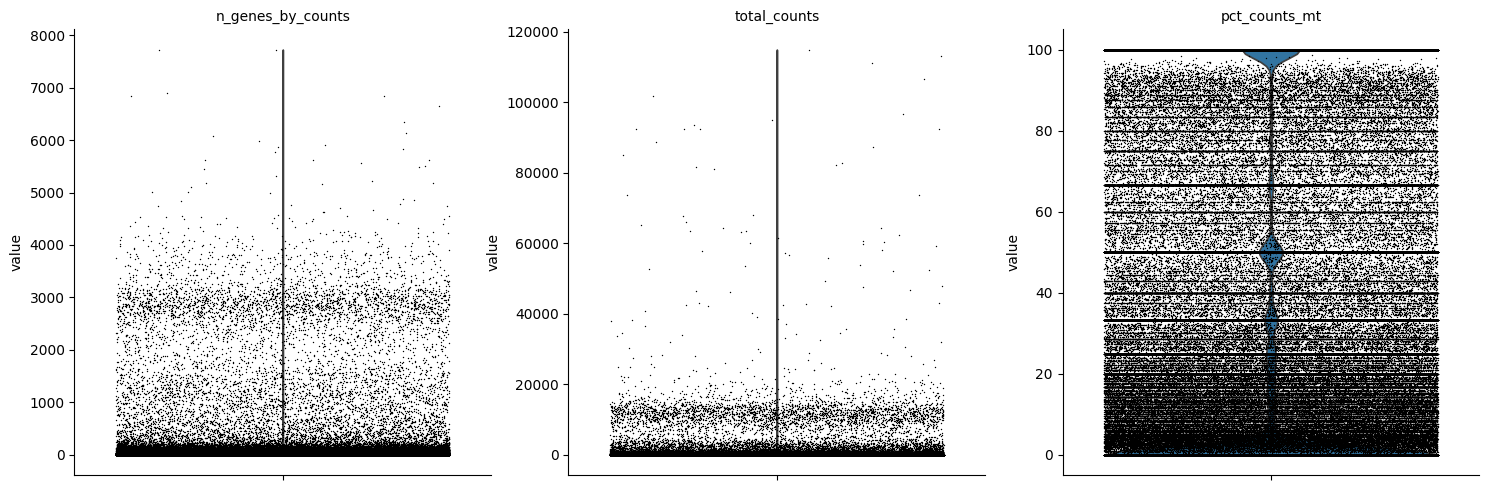

<Figure size 640x480 with 0 Axes>

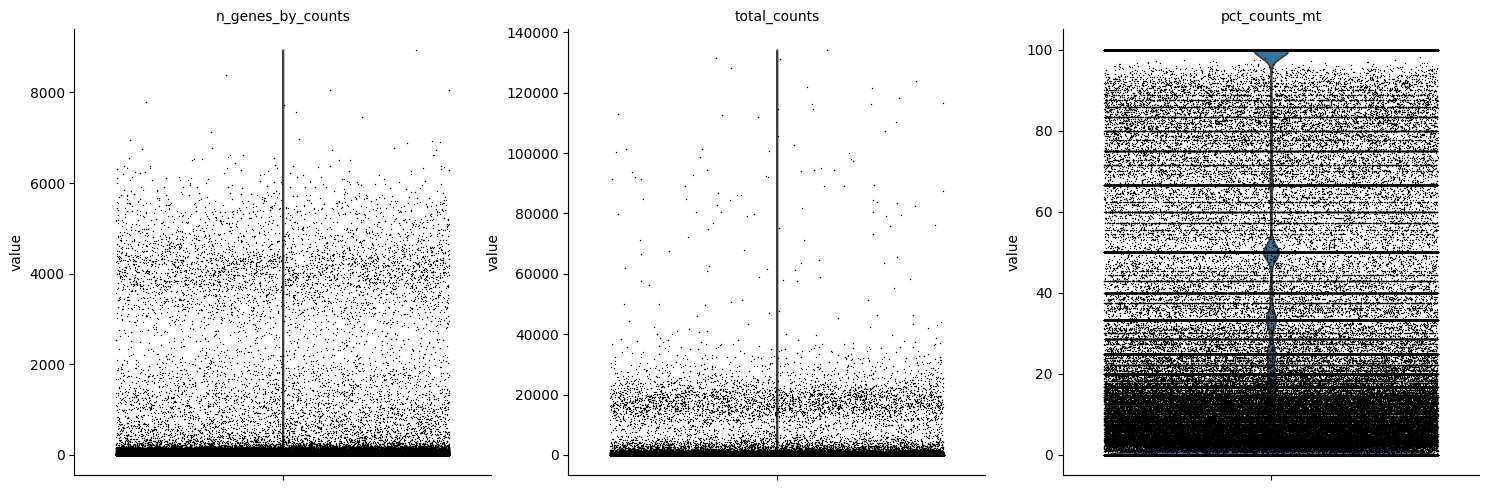

<Figure size 640x480 with 0 Axes>

In [103]:
for sample in samples_uninfected:
    ad = uninfected_dict[sample]
    ad.var['mt'] = ad.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False)
    sc.pl.violin(ad, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
    plt.suptitle(sample)

In [130]:
merged_ad = merge(samples_uninfected, uninfected_dict, uninfected_cells)
merged_ad

/loc/scratch/5745563/ipykernel_4515/1755815239.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad = ad.concatenate(sample_dict[sample][sample_cells[sample]],
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/loc/scratch/5745563/ipykernel_4515/1755815239.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future.

AnnData object with n_obs × n_vars = 14327040 × 55432
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'

In [132]:
merged_ad.obs_names_make_unique()

In [133]:
merged_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch
barcode,,,,,,
AAACCTGAGAAACCAT-1,GSM5182803_10x-Estes-02,39,42.0,3.0,7.142858,0
AAACCTGAGAAACCGC-1,GSM5182803_10x-Estes-02,0,0.0,0.0,NaN,0
AAACCTGAGAAACCTA-1,GSM5182803_10x-Estes-02,0,0.0,0.0,NaN,0
AAACCTGAGAAACGAG-1,GSM5182803_10x-Estes-02,0,0.0,0.0,NaN,0
AAACCTGAGAAACGCC-1,GSM5182803_10x-Estes-02,0,0.0,0.0,NaN,0
...,...,...,...,...,...,...
TTTGTTGTCTTTGCTA-1-1,GSM5182806_10x-Estes-05,0,0.0,0.0,NaN,1
TTTGTTGTCTTTGCTG-1-1,GSM5182806_10x-Estes-05,0,0.0,0.0,NaN,1
TTTGTTGTCTTTGGAG-1-1,GSM5182806_10x-Estes-05,2,2.0,1.0,50.000000,1


In [134]:
merged_ad.obs['sample'].unique()

['GSM5182803_10x-Estes-02', 'GSM5182804_10x-Estes-03', 'GSM5182806_10x-Estes-05']
Categories (3, object): ['GSM5182803_10x-Estes-02', 'GSM5182804_10x-Estes-03', 'GSM5182806_10x-Estes-05']

In [135]:
merged_ad = merged_ad[(merged_ad.obs.pct_counts_mt < 25), :]
merged_ad

View of AnnData object with n_obs × n_vars = 2164957 × 55432
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'

In [136]:
sc.pp.filter_cells(merged_ad, min_genes=100)
sc.pp.filter_genes(merged_ad, min_cells=3)
merged_ad

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


AnnData object with n_obs × n_vars = 26075 × 22189
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_genes'
    var: 'n_cells'

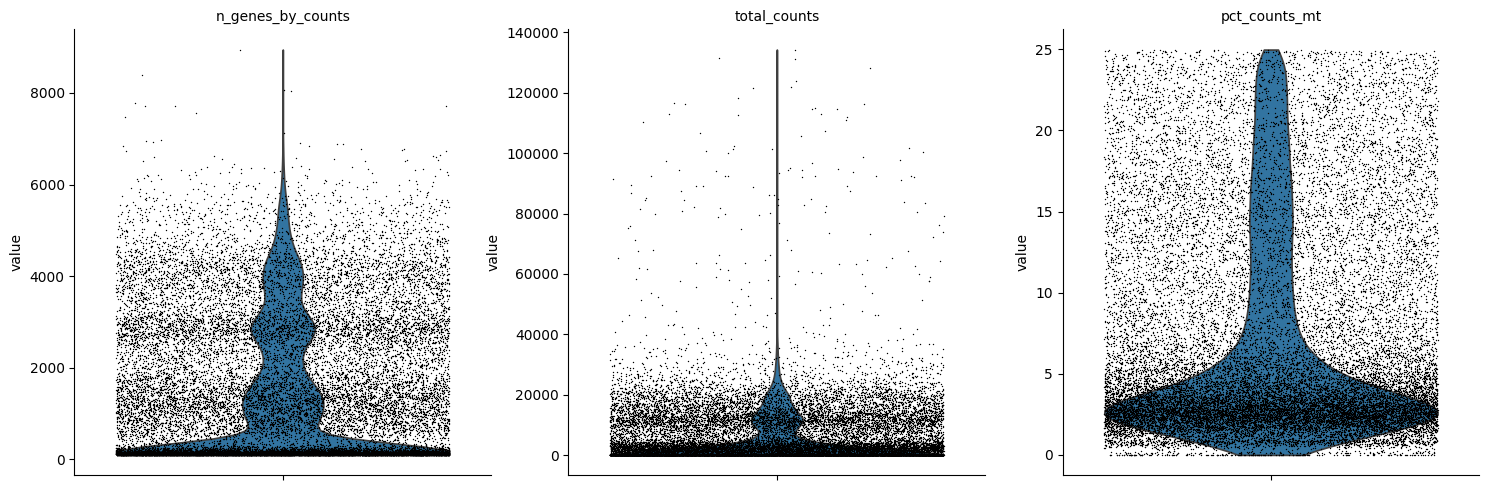

In [137]:
sc.pl.violin(merged_ad, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.4, multi_panel=True)

## Normalization

In [138]:
# Saving count data
merged_ad.layers["counts"] = merged_ad.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(merged_ad)

# Logarithmize the data
sc.pp.log1p(merged_ad)

## Feature Selection

In [141]:
sc.pp.highly_variable_genes(merged_ad, n_top_genes=2000, batch_key='batch')

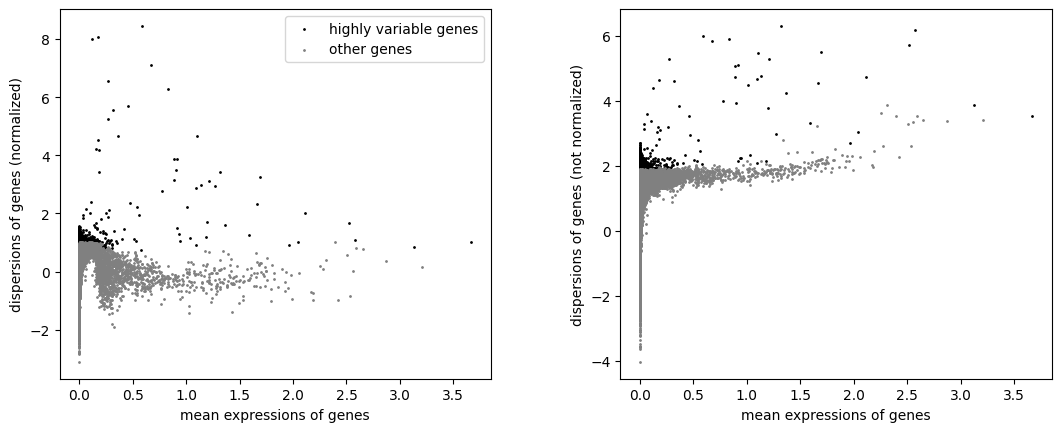

In [142]:
sc.pl.highly_variable_genes(merged_ad)

In [143]:
merged_ad

AnnData object with n_obs × n_vars = 26075 × 22189
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

## Dimensionality Reduction

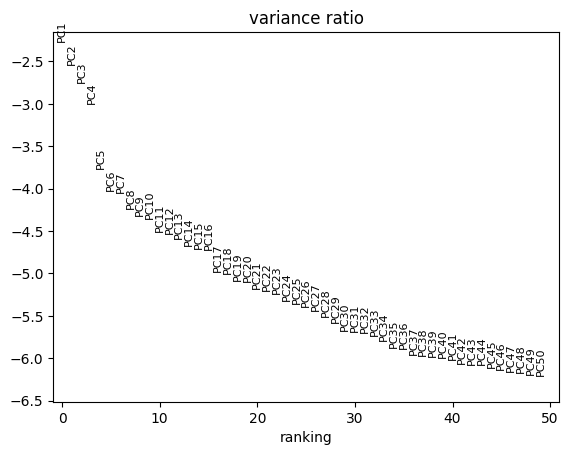

In [144]:
sc.tl.pca(merged_ad)
sc.pl.pca_variance_ratio(merged_ad, n_pcs=50, log=True)

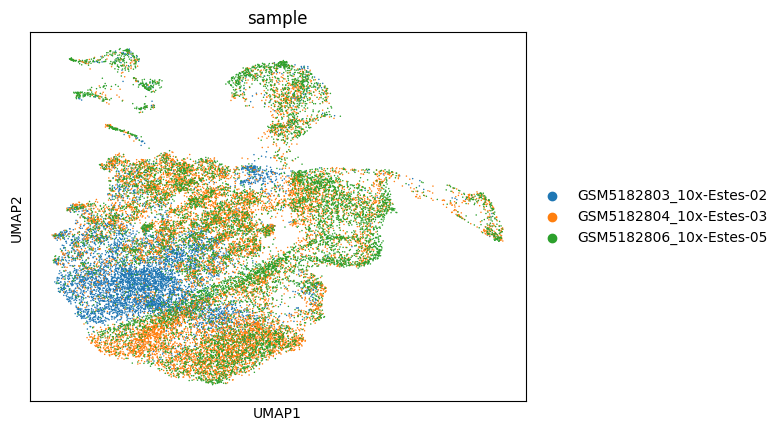

In [145]:
sc.pp.neighbors(merged_ad)
sc.tl.umap(merged_ad)
sc.pl.umap(merged_ad, color='sample')

## Cell Type Annotation

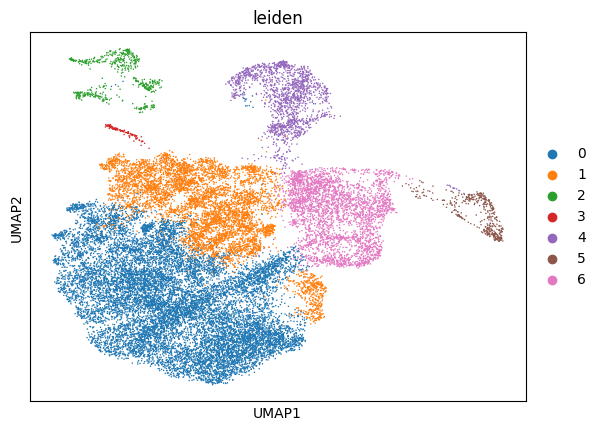

In [147]:
sc.tl.leiden(merged_ad, flavor="igraph", n_iterations=2, resolution=0.1)
sc.pl.umap(merged_ad, color=["leiden"])

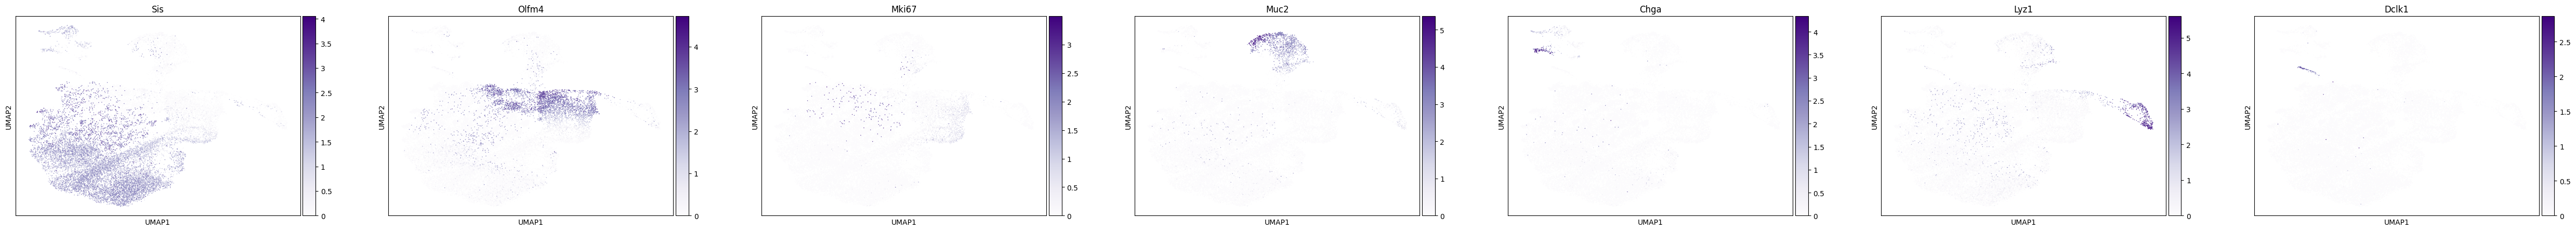

In [148]:
sc.pl.scatter(merged_ad, basis='umap', color=['Sis', 'Olfm4','Mki67', 'Muc2', 'Chga', 'Lyz1', 'Dclk1'], frameon=True, color_map='Purples')

Sis - Enterocyte  
Olfm4 - Stem  
Mki67 - Stem/TA  
Muc2 - Goblet  
Chga - EEC  
Lyz1 - Paneth  
Dclk1 - Tuft  

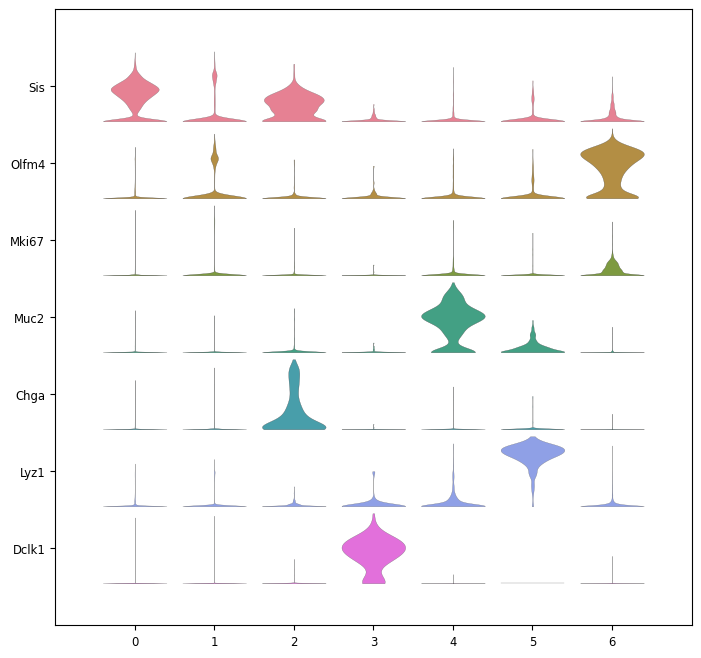

In [151]:
sc.pl.stacked_violin(merged_ad, ['Sis', 'Olfm4','Mki67', 'Muc2', 'Chga', 'Lyz1', 'Dclk1'],
                     row_palette='husl', groupby='leiden', swap_axes=True, figsize=(10,8), standard_scale='var')

In [154]:
cell_types = pd.Series("", index=merged_ad.obs['leiden'].values.categories)
cell_types['0'] = 'Enterocytes'
cell_types['1'] = 'Stem'
cell_types['2'] = 'EEC'
cell_types['3'] = 'Tuft'
cell_types['4'] = 'Goblet'
cell_types['5'] = 'Paneth'
cell_types['6'] = 'Stem/TA'

merged_ad.obs['celltype'] = cell_types[merged_ad.obs['leiden']].values
merged_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,leiden,celltype
barcode,,,,,,,,,
AAACCTGAGCCAGAAC-1,GSM5182803_10x-Estes-02,774,1335.0,220.0,16.479401,0,774,0,Enterocytes
AAACCTGAGCCAGTAG-1,GSM5182803_10x-Estes-02,786,1885.0,256.0,13.580902,0,786,0,Enterocytes
AAACCTGAGCTGAAAT-1,GSM5182803_10x-Estes-02,1891,5119.0,138.0,2.695839,0,1891,0,Enterocytes
AAACCTGAGTACACCT-1,GSM5182803_10x-Estes-02,2027,7556.0,151.0,1.998412,0,2027,1,Stem
AAACCTGCACTAGTAC-1,GSM5182803_10x-Estes-02,178,245.0,6.0,2.448980,0,178,0,Enterocytes
...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTATGTGC-1-1,GSM5182806_10x-Estes-05,1866,3554.0,422.0,11.873945,1,1866,0,Enterocytes
TTTGTTGGTTCTATCT-1-1,GSM5182806_10x-Estes-05,101,109.0,3.0,2.752294,1,101,1,Stem
TTTGTTGTCCCATGGG-1-1,GSM5182806_10x-Estes-05,142,177.0,6.0,3.389831,1,142,1,Stem


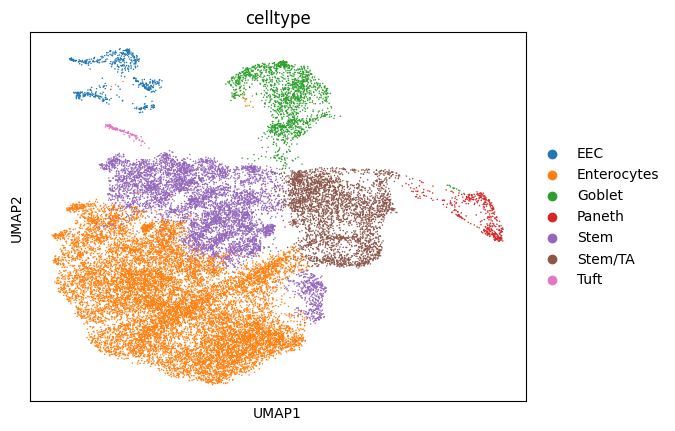

In [155]:
sc.pl.umap(merged_ad, color=["celltype"])

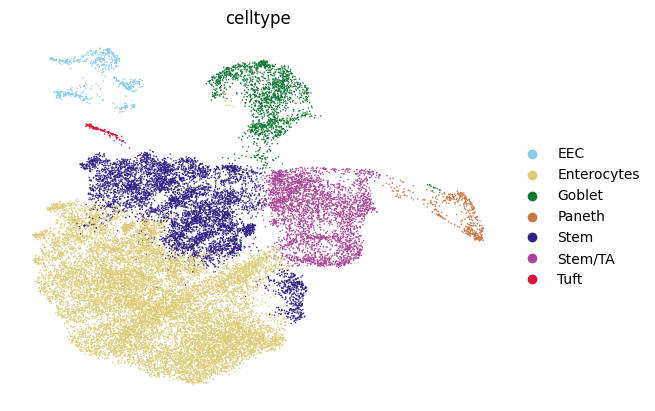

In [158]:
colors = [
    "#88CCEE",  # Light blue for EEC
    "#DDCC77",  # Warm yellow for Enterocytes
    "#117733",  # Deep green for Goblet
    "#CB7745",  # Orange-brown for Paneth
    "#332288",  # Dark blue for Stem
    "#AA4499",  # Purple for Stem/TA
    "#DC143C"   # Crimson for Tuft
]

# Map the colors to the cell types
merged_ad.uns["celltype_colors"] = colors

# Plot the UMAP
sc.pl.umap(merged_ad, color="celltype", frameon=False)

In [169]:
merged_ad.write('ad_epi.h5ad')

### Version 1

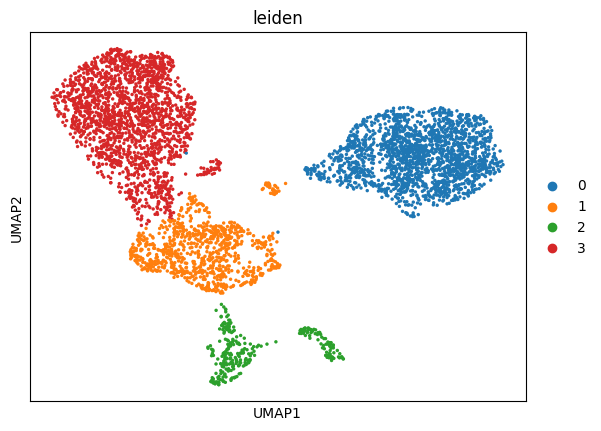

In [131]:
sc.tl.leiden(merged_ad, flavor="igraph", n_iterations=2, resolution=0.06)
sc.pl.umap(merged_ad, color=["leiden"])

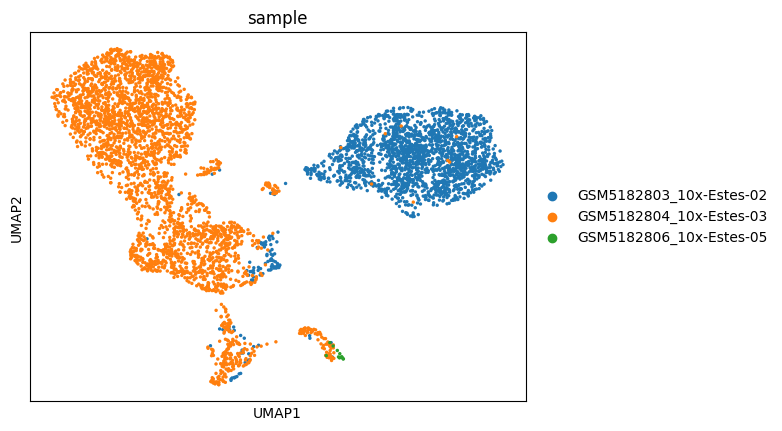

In [132]:
sc.pl.umap(merged_ad, color=["sample"])

# Morarach Enteric Neurons Data

In [159]:
ad_mn = sc.read_h5ad('ad_mn.h5ad')
ad_mn

AnnData object with n_obs × n_vars = 5354 × 18039
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_genes', 'n_counts', 'leiden_1.5', 'leiden', 'leiden_0.4', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_1.5', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [160]:
ad_mn.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6,ENC10
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2,ENC3


In [161]:
merged_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,leiden,celltype
barcode,,,,,,,,,
AAACCTGAGCCAGAAC-1,GSM5182803_10x-Estes-02,774,1335.0,220.0,16.479401,0,774,0,Enterocytes
AAACCTGAGCCAGTAG-1,GSM5182803_10x-Estes-02,786,1885.0,256.0,13.580902,0,786,0,Enterocytes
AAACCTGAGCTGAAAT-1,GSM5182803_10x-Estes-02,1891,5119.0,138.0,2.695839,0,1891,0,Enterocytes
AAACCTGAGTACACCT-1,GSM5182803_10x-Estes-02,2027,7556.0,151.0,1.998412,0,2027,1,Stem
AAACCTGCACTAGTAC-1,GSM5182803_10x-Estes-02,178,245.0,6.0,2.448980,0,178,0,Enterocytes
...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTATGTGC-1-1,GSM5182806_10x-Estes-05,1866,3554.0,422.0,11.873945,1,1866,0,Enterocytes
TTTGTTGGTTCTATCT-1-1,GSM5182806_10x-Estes-05,101,109.0,3.0,2.752294,1,101,1,Stem
TTTGTTGTCCCATGGG-1-1,GSM5182806_10x-Estes-05,142,177.0,6.0,3.389831,1,142,1,Stem


In [163]:
ad_mn.obs[ad_mn.obs['celltype'] == 'ENC6']

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAAGGGCTCTTTCCAA-1,P21_1,7046,53505.0,2408.0,4.500514,0,7045,53504.0,10,11,7,ENC6
AAAGGTAAGCAACTCT-1,P21_1,6169,45615.0,2275.0,4.987394,0,6167,45613.0,10,11,7,ENC6
AAAGTCCTCACAGTGT-1,P21_1,5575,25104.0,4077.0,16.240440,0,5574,25103.0,10,11,7,ENC6
AATGACCCATTGTAGC-1,P21_1,5493,25252.0,1849.0,7.322192,0,5493,25252.0,10,11,7,ENC6
ACATCCCCACAACCGC-1,P21_1,6242,33697.0,5014.0,14.879663,0,6241,33696.0,10,11,7,ENC6
...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCACGAGCATGAAT-1,P21_2,1674,3493.0,9.0,0.257658,1,1674,3493.0,10,11,7,ENC6
TTGGGATTCGAACCTA-1,P21_2,4711,19622.0,4374.0,22.291306,1,4708,19619.0,10,11,7,ENC6
TTGGGCGGTACCCGAC-1,P21_2,4747,21458.0,3295.0,15.355578,1,4746,21457.0,10,11,7,ENC6


In [162]:
merged_ad.obs[merged_ad.obs['celltype'] == 'Tuft']

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,leiden,celltype
barcode,,,,,,,,,
CAAGATCAGATTACCC-1,GSM5182803_10x-Estes-02,821,1975.0,82.0,4.151898,0,821,3,Tuft
CTCGGAGCACCAGCAC-1,GSM5182803_10x-Estes-02,2957,10233.0,137.0,1.338806,0,2957,3,Tuft
CTGTTTAGTTACGCGC-1,GSM5182803_10x-Estes-02,1677,4296.0,43.0,1.000931,0,1677,3,Tuft
GACGCGTAGATGTAAC-1,GSM5182803_10x-Estes-02,2341,6401.0,97.0,1.515388,0,2341,3,Tuft
GCGGGTTTCATCTGTT-1,GSM5182803_10x-Estes-02,2464,7690.0,109.0,1.417425,0,2464,3,Tuft
...,...,...,...,...,...,...,...,...,...
TGTGATGAGCGATGAC-1-1,GSM5182806_10x-Estes-05,2075,5173.0,302.0,5.838005,1,2075,3,Tuft
TTACAGGCATGCGTGC-1-1,GSM5182806_10x-Estes-05,3724,11528.0,116.0,1.006246,1,3724,3,Tuft
TTACCGCAGCTGAGCA-1-1,GSM5182806_10x-Estes-05,112,117.0,2.0,1.709402,1,112,3,Tuft


In [170]:
# Create AnnData object with both neuron and epithelial cell data 
ad = merged_ad.concatenate(ad_mn, batch_key='batch')
ad

/loc/scratch/5745563/ipykernel_4515/975084846.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad = merged_ad.concatenate(ad_mn, batch_key='batch')


AnnData object with n_obs × n_vars = 31429 × 14701
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_genes', 'leiden', 'celltype', 'n_counts', 'leiden_1.5', 'leiden_0.4'
    var: 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_umap'

In [171]:
ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,leiden,celltype,n_counts,leiden_1.5,leiden_0.4
barcode,,,,,,,,,,,,
AAACCTGAGCCAGAAC-1-0,GSM5182803_10x-Estes-02,774,1335.0,220.0,16.479401,0,774,0,Enterocytes,NaN,NaN,NaN
AAACCTGAGCCAGTAG-1-0,GSM5182803_10x-Estes-02,786,1885.0,256.0,13.580902,0,786,0,Enterocytes,NaN,NaN,NaN
AAACCTGAGCTGAAAT-1-0,GSM5182803_10x-Estes-02,1891,5119.0,138.0,2.695839,0,1891,0,Enterocytes,NaN,NaN,NaN
AAACCTGAGTACACCT-1-0,GSM5182803_10x-Estes-02,2027,7556.0,151.0,1.998412,0,2027,1,Stem,NaN,NaN,NaN
AAACCTGCACTAGTAC-1-0,GSM5182803_10x-Estes-02,178,245.0,6.0,2.448980,0,178,0,Enterocytes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,15,ENC11,48459.0,25,11
TTTGATCCATGACTGT-1-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,1,ENC1,19084.0,2,0
TTTGGTTGTCTGCGCA-1-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,2,ENC3,24847.0,4,2


In [172]:
ad.obs['sample'].unique()

['GSM5182803_10x-Estes-02', 'GSM5182804_10x-Estes-03', 'GSM5182806_10x-Estes-05', 'P21_1', 'P21_2']
Categories (5, object): ['GSM5182803_10x-Estes-02', 'GSM5182804_10x-Estes-03', 'GSM5182806_10x-Estes-05', 'P21_1', 'P21_2']

In [173]:
ad.write('ad_merged_neuron_epithelial_data.h5ad')

In [175]:
celltype_counts = ad.obs['celltype'].value_counts()
celltype_counts

celltype
Enterocytes    13817
Stem            6243
Stem/TA         3248
Goblet          1657
ENC1            1392
ENC8            1160
ENC3             881
ENC2             656
EEC              572
Paneth           418
ENC9             257
ENC7             253
ENC10            253
ENC6             193
ENC12            185
Tuft             120
ENC5              50
ENC4              44
ENC11             30
Name: count, dtype: int64

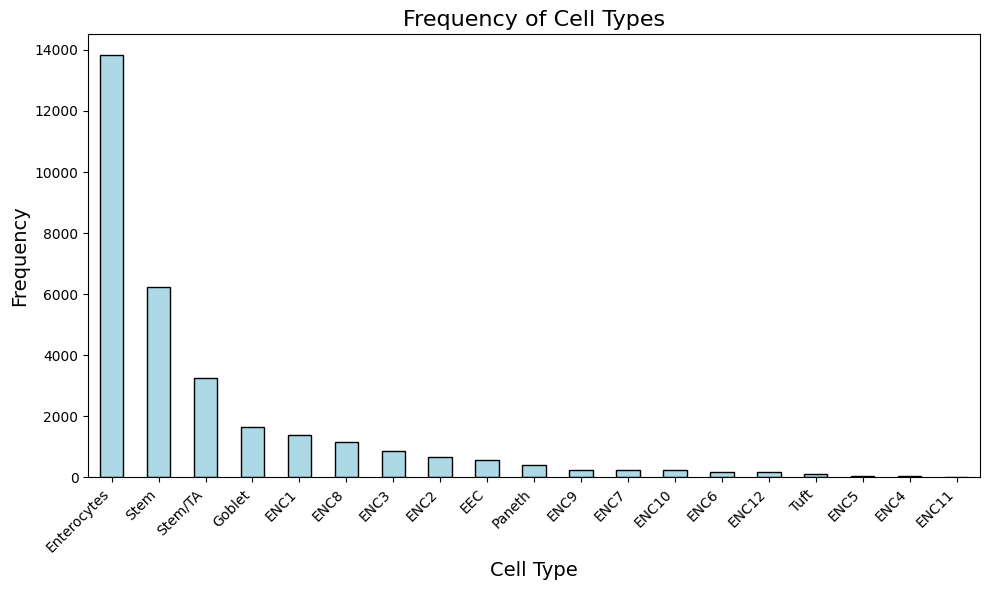

In [176]:
# Create a bar plot
plt.figure(figsize=(10, 6))
celltype_counts.plot(kind='bar', color='lightblue', edgecolor='black')

# Customize the plot
plt.title('Frequency of Cell Types', fontsize=16)
plt.xlabel('Cell Type', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()
